<a href="https://colab.research.google.com/github/saadhashmi91/Meeshkan-TwitterAuthorhipAttributionChallenge/blob/master/Authorship_Attribution_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

#Upload training_set nnd test_set from url
train_set_url='https://raw.githubusercontent.com/SaadHashmiVeon/TwitterAuthorAttribution/master/train_set.csv'
test_set_url = 'https://raw.githubusercontent.com/SaadHashmiVeon/TwitterAuthorAttribution/master/test_set.csv'

df = pd.read_csv(train_set_url,lineterminator='\n')
test_df=pd.read_csv(test_set_url,lineterminator='\n')
df.head(5)
test_df.head(5)

,author,day,month,year,hour,minute,second,day_of_week,day_of_year,week_of_year,source,lang,is_retweet,has_hashtag,has_mentions,has_url,has_media,tweet
0,NaN,4,11,2011,13,14,11,Fri,308,44,26,en,False,False,False,True,False,Just got this photo... seems like everything i...
1,NaN,8,12,2014,20,41,35,Mon,342,49,2,en,False,False,True,True,False,"In Arizona, a group of @OFA fellows have becom..."
2,NaN,16,4,2015,18,37,1,Thu,106,15,2,en,False,False,False,False,False,"""We shouldn't have to choose between rewarding..."
3,NaN,31,1,2019,6,30,51,Thu,31,4,2,en,False,True,False,True,False,west coast we on! #JokersWild https://t.co/8KG...
4,NaN,6,10,2016,18,35,27,Thu,280,40,2,en,False,True,False,True,False,ICYMI: Read about the historic #ParisAgreement...


# Twitter Authorship Attribution

> ## Introduction
The goal of the assigned coding challenge is to implement a Machine Learning or Deep Learning algorithm for predicting correct Twitter Author names for a  given  test-set containing tweets without author name information and an accompanying training-set having a larger number of example tweets with author name information.

> To this end, I have chosen to implement a Deep Learning Alogrithm to complete the task. The following code is an implementation of a Deep Learning Algorithm for small text classification.

> ## Algorithm Description
The algorithm defines a basic Deep Learning architecture for NLP: the 1D CNN. The original papers for this model are [[1](https://arxiv.org/abs/1408.5882),[2](https://arxiv.org/abs/1412.1058)]. Though the orginal algorithms are targeted at the task of binary-class text classification, the algorithms can be adapted to the task of Authorship Attribution which is a general case known as multi-class text classification.

>## Multi-Class Classification
One-of-many classification. Each sample can belong to ONE of C
classes. The CNN will have C output neurons that can be gathered in a vector s (Scores). The target (ground truth) vector t will be a one-hot vector with a positive class and C−1 negative classes. This task is treated as a single classification problem of samples in one of C classes.

>>### Loss
The loss that the model will learn to minimize is the log loss, also known as the cross entropy. In a multi-class classification setting with 1-C classes, the log loss is a Softmax activation plus a Cross-Entropy loss. If we use this loss, we will train a CNN to output a probability over the C classes for each input.
![alt text](https://drive.google.com/uc?export=view&id=1pXJQaq3WkMGauHvXtlDrTM5AWczrderI)




>## Algorithm Implementation
The algorithm is implemented using Python 3.6, Keras 2.2.5 with TensorFlow as backend.

>## Run Instructions:
In order to run the complete training,validation and prediction pipeline, open **Runtime Tab** in this notebook and select **Run All** or just press **Ctrl + F9**. At the end of the pipeline the test results will can be downloaded as ***test_results.csv*** by the prompt dialog. ***Note***: Kindly re-run the ***last cell*** in case there is a network error to download the ***test_results.csv***.




In [0]:
#Concatenate Year,Month,Day into Date:
df['date_time'] = pd.to_datetime(df[['year', 'month','day','hour']])
df['date'] = df['date_time'].dt.date
test_df['date_time'] = pd.to_datetime(test_df[['year', 'month','day','hour']])
test_df['date'] = test_df['date_time'].dt.date
df.head(10)
test_df.head(10)

,author,day,month,year,hour,minute,second,day_of_week,day_of_year,week_of_year,source,lang,is_retweet,has_hashtag,has_mentions,has_url,has_media,tweet,date_time,date
0,NaN,4,11,2011,13,14,11,Fri,308,44,26,en,False,False,False,True,False,Just got this photo... seems like everything i...,2011-11-04 13:00:00,2011-11-04
1,NaN,8,12,2014,20,41,35,Mon,342,49,2,en,False,False,True,True,False,"In Arizona, a group of @OFA fellows have becom...",2014-12-08 20:00:00,2014-12-08
2,NaN,16,4,2015,18,37,1,Thu,106,15,2,en,False,False,False,False,False,"""We shouldn't have to choose between rewarding...",2015-04-16 18:00:00,2015-04-16
3,NaN,31,1,2019,6,30,51,Thu,31,4,2,en,False,True,False,True,False,west coast we on! #JokersWild https://t.co/8KG...,2019-01-31 06:00:00,2019-01-31
4,NaN,6,10,2016,18,35,27,Thu,280,40,2,en,False,True,False,True,False,ICYMI: Read about the historic #ParisAgreement...,2016-10-06 18:00:00,2016-10-06
5,NaN,5,6,2019,22,9,30,Wed,156,22,4,en,False,False,False,True,False,My new BE KIND Box is available now. And one l...,2019-06-05 22:00:00,2019-06-05
6,NaN,23,1,2019,17,21,18,Wed,23,3,7,en,False,False,False,True,False,A comprehensive overview and break-down of 14 ...,2019-01-23 17:00:00,2019-01-23
7,NaN,29,4,2019,1,15,21,Mon,119,17,0,en,False,True,True,False,True,RT @PlanetKhloeK: Don’t miss part two of the B...,2019-04-29 01:00:00,2019-04-29
8,NaN,23,9,2018,20,21,48,Sun,266,38,0,en,False,False,True,True,False,I love him so much I can’t stand it. @drewbree...,2018-09-23 20:00:00,2018-09-23
9,NaN,29,8,2014,15,59,21,Fri,241,34,25,en,False,False,False,True,False,You asked: Say hello to Ireland 😘 http://t.co/...,2014-08-29 15:00:00,2014-08-29


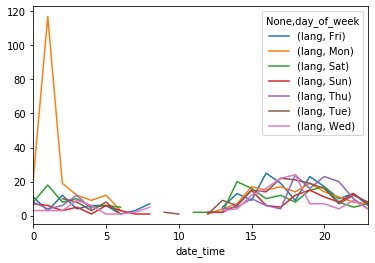

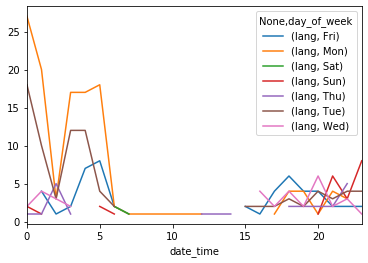

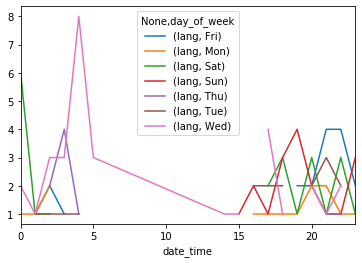

In [0]:
#Create a windowed aggregation by Author and Date to find number of tweets per hour for each day.

# Create variable with TRUE if nationality is USA
kim = df['author'] == "Kim Kardashian West"
kate= df['author'] == "KATY PERRY"
elen= df['author'] == 'Ellen DeGeneres'
# Create variable with TRUE if age is greater than 50
source = df['source'] == 0
year= df['year']==2019
month= df['month']==5
df_kim=df[ kim & source & year ]
df_kate=df[kate & source & year]
df_elen=df[elen & source & year]
#df_elen.sort_values(['author','date']).head(10)

df_kim.sort_values(['author','date_time']).groupby([df['date_time'].dt.hour,'day_of_week'])[['lang']].count().unstack().plot()

df_kate.sort_values(['author','date_time']).groupby([df['date_time'].dt.hour,'day_of_week'])[['lang']].count().unstack().plot()


df_elen.sort_values(['author','date_time']).groupby([df['date_time'].dt.hour,'day_of_week'])[['lang']].count().unstack().plot()



In [0]:
# Text Preprocessing + Vocabulary Building + Author Indexing
from keras.preprocessing import text
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np

TEXT_LIMIT=280

def createTokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def create_tokenizer_char(lines):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(lines)
    return tokenizer

def fill_in_missing_words_with_zeros(embeddings_index, word_index, EMBEDDING_DIM):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length)
    return padded

#Preprocessing Logic:

#Get all distinct authors
authors=df['author'].unique().tolist()

print("Distinct number of authors: " + str(len(authors)))

#Assign unique numeric label to each author
labels_dictionary=dict(enumerate(sorted(authors),1))

#Prepend date as string and source as string to each example. Concatenate test and train data into single list
df['joined'] = df['date'].map(str) + ' ' + df['hour'].map(str) + ' ' + df['source'].map(str) + ' ' + df['tweet']
test_df['joined'] =  test_df['date'].map(str) + ' ' + test_df['hour'].map(str) + ' ' + test_df['source'].map(str) + ' ' + test_df['tweet']
train_list = df['joined'].tolist()
test_list = test_df['joined'].tolist()
merged_lst =  train_list + test_list


#Create parallel lists of example and label
tuples_list= [(list(labels_dictionary.keys())[list(labels_dictionary.values()).index(row['author'])], row['joined']) for index, row in df.iterrows()]
y_label,x_text=list(zip(*tuples_list))

#Create tokenizer
tokenizer = createTokenizer(merged_lst)

#Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
 
#Encode the list of text by converting to sequence and PAD the sequences, where TEXT_LIMIT=280
x = encode_text(tokenizer,x_text,TEXT_LIMIT)
print('Shape of data tensor:', x.shape)


#For Evaluation Phase
x_eval=encode_text(tokenizer,test_list,TEXT_LIMIT)
print('Shape of test data tensor:', x_eval.shape)


#Convert labels to categorical vectors
y = to_categorical(y_label, num_classes=None)


# Randomly shuffle data
shuffle_indices = np.arange(x.shape[0])
np.random.shuffle(shuffle_indices)
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# split the data into a training set and a validation set
dev_sample_index = -1 * int(0.10 * float(len(y)))  # validation set 10 percent

x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
y_label_val = y_label[dev_sample_index:]

del x, x_shuffled, y_shuffled




print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Distinct number of authors: 10
Vocabulary size: 58759
Shape of data tensor: (23164, 280)
Shape of test data tensor: (5791, 280)
Train/Dev split: 20848/2316


 The following figure depicts a toy example of the 1D-CNN architecture for text classification with an input document of size s = 7, word vectors of dimensionality d = 5, 3 branches corresponding to filters of sizes h = 2, 3, 4 , n f = 2 filters per branch, 1-max global pooling, and 2 categories. Adapted from [[1](https://arxiv.org/abs/1412.1058)].

![](https://drive.google.com/uc?export=view&id=1Wk1uUeBs3FOiocPqLUqOR6vL7VdQaqIm)


In [0]:
#Define a 1-Dimensional CNN python class for Text Classification
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Dense


class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    #Adds a convolution and a pooling layer
    def cnn_branch(self,idx,my_input):
      x = Conv1D(self.nb_filters, self.filter_sizes[idx], activation="relu",name="conv-"+str(idx))(my_input)
      x = GlobalMaxPooling1D()(x) # Global Maxpooling over the outputs
      return Dropout(self.dropout_rate)(x)

    def __init__(
      self, num_classes, word_index,MAX_SEQUENCE_LENGTH,
      embedding_size):

        # Member Variables  
        self.dropout_rate = 0.3 #amount of dropout regularization
        self.nb_branches = 2
        self.nb_filters = 50 #number of filters per branch
        self.filter_sizes= [3,4] 
        self.optimizer = 'adam'

        #Define an empty  model usinf Keras Functional API
        print('Build model...')
        doc_ints = Input(shape=(None,))

        #Add an Embedding layer
        #an efficient embedding layer which maps our vocab indices into embedding_size dimensions
        doc_wv = Embedding(input_dim = len(word_index) + 1, output_dim=embedding_size, input_length=MAX_SEQUENCE_LENGTH)(doc_ints)

        #Add Dropout Layer
        doc_wv_dr = Dropout(self.dropout_rate)(doc_wv)

        branch_outputs = []
        
        for idx in range(self.nb_branches):
          x=self.cnn_branch(idx,doc_wv_dr)
          branch_outputs.append(x)
        
        concat = Concatenate()(branch_outputs) # branch output combination

        preds = Dense(num_classes, activation="softmax",name='dense-1')(concat)

        model = Model(doc_ints,preds)

        model.compile(loss='categorical_crossentropy',
                  optimizer=self.optimizer,
                  metrics=['acc'])
        
        print('model compiled')
        model.summary()
        self.model=model
        print('total number of model parameters:',model.count_params())

In [0]:
# Test Define TextCNN model for Visualization
word_index = tokenizer.word_index
num_classes= len(authors) + 1 # 10 as counted before
model_ins = TextCNN(num_classes = num_classes, word_index=word_index,MAX_SEQUENCE_LENGTH=TEXT_LIMIT,embedding_size = 30)

# Restrict label max value to num_classes in y_label_val (Validation Set Labels) (For Visualization purpose only)
# y_label_val=[ label % num_classes + 1 for idx,label in enumerate(y_label_val)  ]

Build model...
model compiled
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 280, 30)      1762770     input_9[0][0]                    
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 280, 30)      0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv-0 (Conv1D)                 (None, 278, 50)      4550        dropout_25[0][0]                 
______________________________________________________________

<class 'tuple'>
plotting embeddings of first 1000 documents


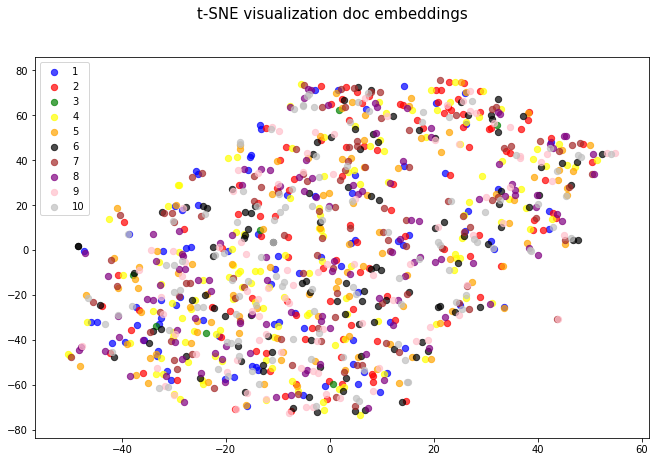

In [0]:
# = = = = = visualizing doc embeddings (before training) = = = = = #

from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def visualize_doc_embeddings(my_doc_embs,my_colors,my_labels,my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)

    #print(doc_embs_tsne.shape)
    
    fig, ax = plt.subplots()
    
    for label in list(set(my_labels)):
        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[label-1],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.pdf')

### create a K.function 'get_doc_embedding()' that returns the inner representation of the model before the prediction layer ###
### this function should take as input the input of the model and return the output of the penultimate layer ###

model=model_ins.model
get_doc_embedding = K.function([model.layers[0].input],[model.get_layer('dense-1').input])

n_plot = 1000
labels_plt = y_label_val[:n_plot]
print(type(labels_plt))

doc_embs = get_doc_embedding([np.array(x_dev[:n_plot]),0])[0]

print('plotting embeddings of first',n_plot,'documents')
visualize_doc_embeddings(doc_embs,['blue','red','green','yellow','orange','black','brown','purple','pink','silver'],(labels_plt),'before')



(20848, 280)
(20848, 11)
Train on 20848 samples, validate on 2316 samples
Epoch 1/10
20848/20848 [==============================] - 6s 308us/step - loss: 1.6652 - acc: 0.4247 - val_loss: 0.8964 - val_acc: 0.6973
Epoch 2/10
20848/20848 [==============================] - 4s 191us/step - loss: 0.8007 - acc: 0.7472 - val_loss: 0.5086 - val_acc: 0.8402
Epoch 3/10
20848/20848 [==============================] - 4s 189us/step - loss: 0.4800 - acc: 0.8561 - val_loss: 0.3557 - val_acc: 0.8895
Epoch 4/10
20848/20848 [==============================] - 4s 190us/step - loss: 0.3022 - acc: 0.9146 - val_loss: 0.2785 - val_acc: 0.9154
Epoch 5/10
20848/20848 [==============================] - 4s 190us/step - loss: 0.1902 - acc: 0.9494 - val_loss: 0.2472 - val_acc: 0.9279
Epoch 6/10
20848/20848 [==============================] - 4s 191us/step - loss: 0.1245 - acc: 0.9671 - val_loss: 0.2331 - val_acc: 0.9301
Epoch 7/10
20848/20848 [==============================] - 4s 191us/step - loss: 0.0904 - acc: 0.97

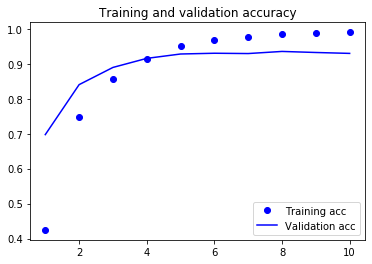

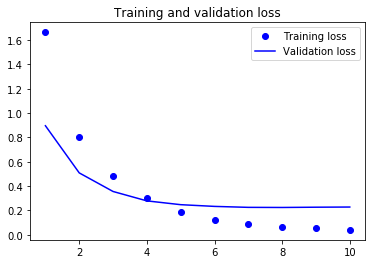

In [0]:
# = = = = = Training Phase= = = = = #

print(x_train.shape)
print(y_train.shape)

batch_size = 64
nb_epochs = 10

history = model.fit(np.array(x_train),
          y_train,
          batch_size = batch_size,
          epochs = nb_epochs,
          validation_data = (np.array(x_dev), y_dev))

#Display curves of loss and accuracy during Training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plotting embeddings of first 1000 documents


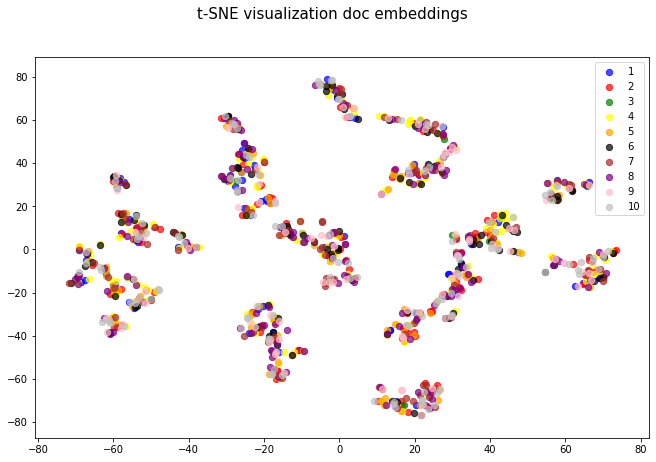

In [0]:
#Visualization of Document Embeddings after Training
doc_embs = get_doc_embedding([np.array(x_dev[:n_plot]),0])[0]

print('plotting embeddings of first',n_plot,'documents')
visualize_doc_embeddings(doc_embs,['blue','red','green','yellow','orange','black','brown','purple','pink','silver'],(labels_plt),'after')


In [0]:
# = = = = = predictive text regions for the first branch = = = = = #

from numpy import linalg as LA

### define a K.function 'get_region_embedding' that returns the feature maps of the first branch ###

get_region_embedding = K.function([model.layers[0].input],[model.get_layer('conv-0').output])

test_tweet = '2015-04-16 18 2 We shouldn\'t have to choose between rewarding work and raising a family." —President Obama'
test_tweet_seq = tokenizer.texts_to_sequences([test_tweet])



tokens = test_tweet.split()

# extract regions (sliding window over text)
filter_sizes = [3,4]
regions = []
regions.append(' '.join(tokens[:filter_sizes[0]]))
for i in range(filter_sizes[0], len(tokens)):
    regions.append(' '.join(tokens[(i-filter_sizes[0]+1):(i+1)]))

test_tweet_seq = np.array(test_tweet_seq)

reg_emb = get_region_embedding([test_tweet_seq,0])[0][0,:,:]

### compute the norms of the region embeddings ###
norms = LA.norm(reg_emb,axis=(1))

zipped = [list(zip(regions,norms)) for idx in np.argsort(-norms).tolist()]

print(zipped)

[[('2015-04-16 18 2', 1.648366), ('18 2 We', 0.32052934), ("2 We shouldn't", 0.99044394), ("We shouldn't have", 0.67258716), ("shouldn't have to", 2.1346104), ('have to choose', 0.9120297), ('to choose between', 0.84900314), ('choose between rewarding', 0.22648914), ('between rewarding work', 0.24620531), ('rewarding work and', 0.27532214), ('work and raising', 0.48528758), ('and raising a', 0.32942832), ('raising a family."', 0.20915858), ('a family." —President', 0.22390583), ('family." —President Obama', 0.21084253)], [('2015-04-16 18 2', 1.648366), ('18 2 We', 0.32052934), ("2 We shouldn't", 0.99044394), ("We shouldn't have", 0.67258716), ("shouldn't have to", 2.1346104), ('have to choose', 0.9120297), ('to choose between', 0.84900314), ('choose between rewarding', 0.22648914), ('between rewarding work', 0.24620531), ('rewarding work and', 0.27532214), ('work and raising', 0.48528758), ('and raising a', 0.32942832), ('raising a family."', 0.20915858), ('a family." —President', 0.22

In [0]:
  # save the model
import os
import time
import datetime

# Output directory for models
timestamp = str(int(time.time()))
out_dir = os.path.abspath(os.path.join(os.path.curdir, "Twitter_Authorship_Attr/runs", timestamp))
print("Writing to {}\n".format(out_dir))

# Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it

checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model/")
if not os.path.exists(checkpoint_prefix):
   os.makedirs(checkpoint_prefix)

# serialize model to JSON
model_json = model.to_json()
with open(checkpoint_prefix + 'Twitter_Authorship_Attr_CNN_word_model.json', "w") as json_file:
  json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(checkpoint_prefix + 'Twitter_Authorship_Attr' + '_CNN_word_model.h5')
  print("Saved model to disk")

Writing to /content/Twitter_Authorship_Attr/runs/1574095665

Saved model to disk


In [0]:
ls -R Twitter_Authorship_Attr

Twitter_Authorship_Attr:
runs/

Twitter_Authorship_Attr/runs:
1574055064/  1574072695/  1574075137/  1574077896/  1574091847/
1574072563/  1574072790/  1574075582/  1574091264/  1574095665/

Twitter_Authorship_Attr/runs/1574055064:
checkpoints/

Twitter_Authorship_Attr/runs/1574055064/checkpoints:
model/
modelTwitter_Authorship_Attr_CNN_word_model.h5
modelTwitter_Authorship_Attr_CNN_wordmodel.json

Twitter_Authorship_Attr/runs/1574055064/checkpoints/model:

Twitter_Authorship_Attr/runs/1574072563:
checkpoints/

Twitter_Authorship_Attr/runs/1574072563/checkpoints:
model/
modelTwitter_Authorship_Attr_CNN_word_model.h5
modelTwitter_Authorship_Attr_CNN_wordmodel.json

Twitter_Authorship_Attr/runs/1574072563/checkpoints/model:

Twitter_Authorship_Attr/runs/1574072695:
checkpoints/

Twitter_Authorship_Attr/runs/1574072695/checkpoints:
model/
modelTwitter_Authorship_Attr_CNN_word_model.h5
modelTwitter_Authorship_Attr_CNN_word_model.json

Twitter_Authorship_Attr/runs/1574072695/checkpoints/mod

In [0]:
# Model Prediction Phase
from keras.models import model_from_json
from google.colab import files


#Print Test Set Sample
#print(x_eval[:5])

# load json and create model
json_file = open(checkpoint_prefix +'Twitter_Authorship_Attr_CNN_word_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(checkpoint_prefix +'Twitter_Authorship_Attr_CNN_word_model.h5')
print("Loaded model from disk")

#Recompile loaded model
loaded_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

#Evaluate model on test set
out = loaded_model.predict(np.array(x_eval), batch_size=64, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

#print(out.shape)

labels= np.argmax(out, axis=-1)


author_names=[labels_dictionary[label] for idx,label in enumerate(list(labels))]

test_df['author']=author_names

#Save Test Output as csv
test_df.to_csv('test_results.csv')

files.download("test_results.csv")

test_df[['author','joined']].head(10)




Loaded model from disk


,author,joined
0,Cristiano Ronaldo,2011-11-04 13 26 Just got this photo... seems ...
1,Barack Obama,"2014-12-08 20 2 In Arizona, a group of @OFA fe..."
2,Barack Obama,"2015-04-16 18 2 ""We shouldn't have to choose b..."
3,Snoop Dogg,2019-01-31 6 2 west coast we on! #JokersWild h...
4,Barack Obama,2016-10-06 18 2 ICYMI: Read about the historic...
5,Ellen DeGeneres,2019-06-05 22 4 My new BE KIND Box is availabl...
6,Sebastian Ruder,2019-01-23 17 7 A comprehensive overview and b...
7,Kim Kardashian West,2019-04-29 1 0 RT @PlanetKhloeK: Don’t miss pa...
8,Kim Kardashian West,2018-09-23 20 0 I love him so much I can’t sta...
9,Cristiano Ronaldo,2014-08-29 15 25 You asked: Say hello to Irela...
